# Motivation
I'm interested in generating "filtered" versions of boards. These are essentially going to be visually altered Boggle boards that I can overlay over the original image. 

# Setup
The cells below will help to set up this notebook. 

I'll start by configuring the kernel: 

In [1]:
# Change directories to the boggle-vision-api folder
%cd ./..

# Enable the autoreload of modules
%load_ext autoreload
%autoreload 2

d:\data\programming\boggle-vision


Next, for some import statements: 

In [52]:
# General import statements 
import pandas as pd
from tqdm import tqdm
import cv2
import torch
from matplotlib import pyplot as plt
import numpy as np

# Importing custom-built modules
from utils.board_detection import parse_boggle_board
from utils.cnn import BoggleCNN
from utils.visual_filters import transform_and_place_heatmap, generate_activation_heatmap_filter

Finally, we're going to load in the trained "letter detection" CNN:

In [3]:
# Load in the CNN model
net = BoggleCNN()
net.load_state_dict(torch.load("models/boggle_cnn.pth"))

<All keys matched successfully>

# Loading Data
Next, I need to load in some of the data that I'll be running through the net. 

In [4]:
# Open the .csv file containing the labeled boards
board_data_df = pd.read_csv("data/labeled-boards.csv")

# Add a column which is the parsed letter sequence
board_data_df["parsed_letter_sequence"] = board_data_df["letter_sequence"].apply(
    lambda letter_list: letter_list.split(";")
)

# Load all of the images using cv2
file_path_to_image = {}
for row in tqdm(list(board_data_df.head(3).itertuples())):
    file_path_to_image[row.file_path] = cv2.imread(row.file_path)

100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


Now, in order to have something to work with, we'll run one of the boards through the `parse_boggle_board()` method:

In [5]:
test_image = list(file_path_to_image.values())[0]

parsed_board_df, cropped_image, tile_contours_df, activation_viz_list = parse_boggle_board(
    input_image=test_image,
    max_image_height=1200,
    model=net,
    return_list=[
        "parsed_board",
        "cropped_image",
        "tile_contours",
        "activation_visualization",
    ],
)

# Make a dictionary mapping tile index to contour
tile_idx_to_contour_dict = {
    row.tile_sequence_idx: row.contour.squeeze().tolist()
    for row in tile_contours_df.itertuples()
}

# Generating Visual Filters
Below, I'm going to try my hand at generating some filters using the data extracted from the `parse_boggle_board` method:

### Network Activation Heatmap
The first one I want to try: a heatmap of the letter detection network's layer activations! I had [a conversation with ChatGPT](https://chat.openai.com/share/51760bf7-ab0a-4308-99fa-0c2a5e8f4d0d) where I talked about how to do something like this. 

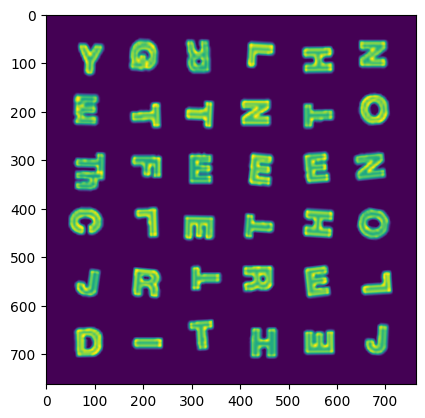

In [53]:
plt.imshow(
    generate_activation_heatmap_filter(
        cropped_image, activation_viz_list, tile_idx_to_contour_dict
    )
)